# Rankine-Hugoniot, la polaire de chocs

On vous propose de mettre en place une feuille de calcul de l'écoulement supersonique autour d'un profil ABC isocèle en B. Les calculs doivent être les plus généraux possibles et paramétrés en particulier par le nombre de Mach `Minf` et l'incidence `aoa`.

`Python` sera utilisé ici comme `matlab`. Des fonctionnalités supplémentaires peuvent être ajoutées par l'import de modules, standards à une distribution (comme `math`, `numpy`) ou personnalisés comme ci-dessous. Des fonctionnalités d'édition sont propres à [`Ipython/Notebook`](#ipython).

In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt
from aerokit.aero import degree    as deg # import trigo functions with degree unit support
from aerokit.aero import ShockWave as sw  # import functions for shockwave computation

Les paramètres suivants sont définis comme des variables globales, que l'on peut utiliser directement dans les fonctions (comme $\gamma$ par exemple).

In [2]:
# definition of problem parameters
gam=1.4
Minf=4.418 ; Tinf=216. ; pinf = 5500.
aoa=0. ; print("angle of attack  (deg): {}".format(aoa))
AB = BC = .5 ; hol = 0.0437 # hol is h/l (h over l)
prof_ang = deg.atan(2.*hol) ; print("angle of profile (deg): {}".format(prof_ang))

angle of attack  (deg): 0.0
angle of profile (deg): 4.99495850403


## Définition des fonctions de transformation à travers le choc

On vous propose tout d'abord de définir les fonctions de saut 1D dépendantes du Mach normal amont. On vérifiera les fonctions implémentées à l'aide des tables.

$$\frac{\rho_1}{\rho_0} = \left( \frac{2}{\gamma+1}\frac{1}{M_{n0}^2} + \frac{\gamma-1}{\gamma+1} \right)^{—1}
\qquad\qquad 
  \frac{P_1}{P_0} =  \frac{2\gamma}{\gamma+1}M_{n0}^2 - \frac{\gamma-1}{\gamma+1} $$

$$ M_{n1}^2 = \frac{1+\frac{\gamma-1}{2} M_{n0}^2}{\gamma M_{n0}^2 - \frac{\gamma-1}{2} } $$

In [6]:
import aerokit.aero.ShockWave as sw

# --- functions implementation ---

def rho_ratio_from_Mn(Mn):
    return sw.Rho_ratio(Mn)
    
def ps_ratio_from_Mn(Mn):
    return sw.Ps_ratio(Mn)

def Mn1_from_Mn(Mn):
    return sw.downstream_Mn(Mn)
    
def pi_ratio_from_Mn(Mn):
    return sw.Pi_ratio(Mn)
    
# --- verification ---
Mnx=2. ; ref = 4.5 ; print("relative error on Ps ratio is {:3.1e}%".format((ps_ratio_from_Mn(Mnx)-ref)/ref*100))

relative error on Ps ratio is 0.0e+00%


On peut maintenant implémenter le calcul de la polaire de choc, soit le calcul direct (voir procédure dans les tables), soit un calcul itératif à partir de
$$ \frac{\tan\sigma}{\tan(\sigma-\theta)}=\frac{\rho_1}{\rho_0}=f(M_0,\sigma) $$

In [10]:
from scipy.optimize import newton

def sigma_from_M0_Dev(M0, dev):
    # definition of the function to solver
    # this function has 4 roots, good initialization is critical to get the right 'weak' solution
    def f_to_solve(sig):
        return deg.tan(sig-dev)*rho_ratio_from_Mn(M0*deg.sin(sig))-deg.tan(sig)
    return newton(f_to_solve, deg.asin(1./M0)+dev) 

# --- verification ---
Mx=2. ; devx=20. ; ref = 53.4229401037; print("relative error on sigma is {:3.1e}%".format((sigma_from_M0_Dev(Mx,devx)-ref)/ref*100))

relative error on sigma is 7.9e-07%


## Polaire angle de choc $\sigma$ et déviation $\theta$

On définit *a minima* la fonction de Prandtl-Meyer $ \tilde{\omega}(M)$ et son inverse.

$$ \tilde{\omega}(M) = \sqrt\frac{\gamma+1}{\gamma-1}\mbox{atan}\sqrt{\frac{\gamma-1}{\gamma+1}(M^2-1)}
       + \mbox{atan}\frac{1}{\sqrt{M^2-1}} - 90°$$

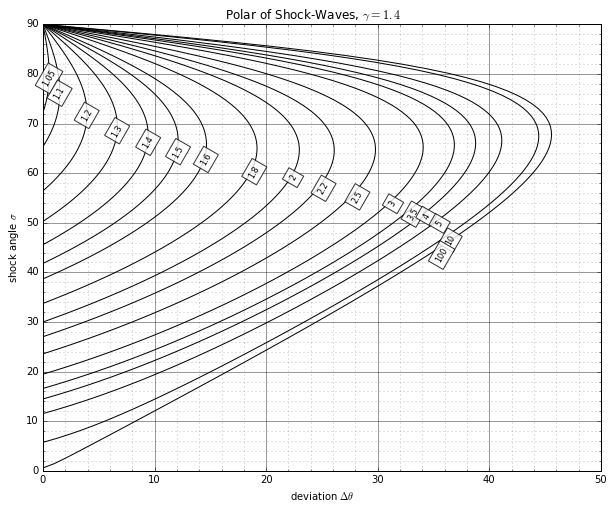

In [5]:
%matplotlib inline
npoints = 100
gam     = 1.4

fig=plt.figure(1, figsize=(10,8))
fig.suptitle('Polar of Shock-Waves, $\gamma = %.1f$'%gam, fontsize=12, y=0.93)

macharray = [ 1.05, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.8, 2., 2.2, 2.5, 3., 3.5, 4., 5., 10., 100. ]

for m in macharray:
    sig = np.linspace(deg.asin(1./m), 90., npoints+1)
    dev = sw.deflection_Mach_sigma(m, sig, gam)
    plt.plot(dev, sig, 'k-')
    plt.text(dev[npoints/2], sig[npoints/2], '%.3g'%m, horizontalalignment='center', verticalalignment='top',
             fontsize=8, bbox=dict(facecolor='white', alpha=0.8),
             rotation='60')
plt.axis([0., 50., 0., 90.])
plt.xlabel('deviation $\Delta\\theta$', fontsize=10)
plt.ylabel('shock angle $\sigma$', fontsize=10)
plt.minorticks_on()
plt.grid(which='major', linestyle='-', alpha=0.8)
plt.grid(which='minor', linestyle=':', alpha=0.5)


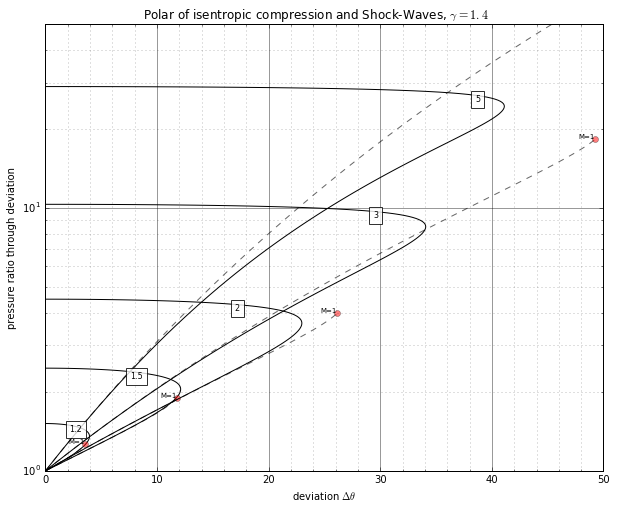

In [14]:
import aerokit.aero.Supersonic as sup

fig=plt.figure(1, figsize=(10,8))
fig.suptitle('Polar of isentropic compression and Shock-Waves, $\gamma = %.1f$'%gam, fontsize=12, y=0.93)

macharray = [ 1.2, 1.5, 2., 3., 5.]
rdev      = np.linspace(0., 50., npoints+1)

for m in macharray:
    sig  = np.linspace(deg.asin(1./m), 90., npoints+1)
    dev  = sw.deflection_Mach_sigma(m, sig, gam)
    kpsw = sw.Ps_ratio(m*deg.sin(sig), gam)     # pressure ratio only depends on normal Mach number
    rdev = np.linspace(0., .99*sup.PrandtlMeyer_Mach(m, gam), npoints+1)
    kpis = sup.IsentropicPsratio_Mach_deflection(m, rdev, gam) 
    plt.plot(dev,  kpsw, 'k-')
    plt.plot(rdev, kpis, 'k--', alpha=0.6)
    plt.plot(rdev[-1], kpis[-1], 'ro', alpha=0.5)
    plt.text(rdev[-1], kpis[-1], 'M=1', fontsize=7, clip_on='true', horizontalalignment='right') 
    plt.text(dev[4*npoints/5], kpsw[4*npoints/5], '%.3g'%m, horizontalalignment='left', verticalalignment='top',
             fontsize=8, bbox=dict(facecolor='white', alpha=0.8),
             rotation='0')
plt.xlim(0., 50.)
plt.ylim(1., 50.)
plt.xlabel('deviation $\Delta\\theta$', fontsize=10)
plt.ylabel('pressure ratio through deviation', fontsize=10)
plt.yscale('log')
plt.minorticks_on()
plt.grid(which='major', linestyle='-', alpha=0.8)
plt.grid(which='minor', linestyle=':', alpha=0.5)


---

<a id="ipython"></a>
## Ipython et notebook : usage

* le notebook utilise la langage de base python en version améliorée, Ipython, qui permet la complétion des noms (variables, fonctions, modules) avec la touche tabulation
* toutes les cellules peuvent être modifiées par un double-clic et sont réinterprêtées avec `shift-entrée`
* l'ensemble de la feuille peut être exécutée avec le menu `Cell/run all cells`
* **n'oubliez pas de sauvegarder régulièrement votre feuille** (bouton _enregistrer_)


In [1]:
from IPython.core.display import HTML ; HTML(open("./custom.css", "r").read()) # notebook style